# Step 2: Image Preprocessing & Dataset Loading

In this step, we prepare our fruit image dataset for training and evaluation using PyTorch utilities. Preprocessing determines the format and structure of the data and directly affects training speed, model complexity, and overall performance — especially in small-scale, resource-constrained setups like embedded systems.

---

## 2.1 Project Hypotheses Supported

Our design is driven by three formal hypotheses:

1. **Grayscale Hypothesis**  
   > Grayscale input can be as effective as RGB for fruit classification, while reducing memory and compute requirements.

2. **Model Simplicity Hypothesis**  
   > A lightweight custom CNN can perform comparably to MobileNetV2, with significantly fewer resources.

3. **Quantization Hypothesis**  
   > Post-training quantization (float32 → int8) will reduce model size and inference time with minimal accuracy loss.

To support these hypotheses, we initially avoided RGB input and data augmentation. However, to further improve generalization and robustness, we now introduce **realistic grayscale-specific augmentations** only for the training set.

---

## 2.2 Preprocessing Strategy

Our preprocessing is designed for compatibility with embedded devices and small datasets, while simulating real-world imperfections that affect shape and lighting.

### Training-time augmentations (applied only to training set):

- **Convert to Grayscale + Histogram Equalization**  
  Enhances contrast and removes color variation by standardizing intensity distribution.

- **Random Horizontal Flip**  
  Simulates mirrored viewpoints.

- **Random Affine (±10° rotation + small translation)**  
  Introduces slight shifts and rotations to simulate camera or object variation.

- **ColorJitter (brightness and contrast)**  
  Simulates differences in lighting conditions.

- **Random Perspective Distortion**  
  Mimics natural viewpoint changes (e.g., lens perspective).

- **Random Shear**  
  Warps fruit shape slightly to help learn deformation-invariant features.

- **Resize to 100×100 pixels**  
  Reduces input size to balance detail with compute/memory constraints.

- **Normalize to [-1, 1]**  
  Ensures consistent scale across samples for stable gradient flow.

### Validation/Test-time preprocessing:

- Clean grayscale input  
- No augmentation  
- Resize → Normalize only

> These augmentations are **only applied to training data**. Validation and test sets remain unaugmented for fair evaluation.



## 2.3 Dataset Loading and Splitting

We use PyTorch’s `ImageFolder` and `DataLoader` APIs to load and split the dataset.

- The training set uses the **augmented grayscale transform**
- The validation and test sets use the **clean grayscale transform** 
- seed=42 is set for **reproducibility**

We also compute inverse-frequency **class weights** to handle imbalance in class frequencies, which will be passed to `CrossEntropyLoss` during training.


In [7]:
####  Note: The class distribution is slightly imbalanced. Class weighting will be applied during training to prevent bias.

In [7]:
import os, sys, numpy as np, torch
sys.path.append(os.path.abspath("../src"))

from data import make_dataloaders
from viz import show_batch


In [8]:
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'
os.makedirs("../reports/figures", exist_ok=True)

train_loader, val_loader, test_loader, class_weights, class_names, in_ch = make_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    batch_size=32,
    val_split=0.2,
    img_size=100,
    num_workers=0,   # safest on Windows
    seed=42,
    verbose=True
)

print("in_channels:", in_ch)
print("Classes:", class_names)
print("Class weights (mean≈1):", class_weights.numpy().round(3))



[INFO] Seed: 42
[INFO] Mode: grayscale (in_channels=1, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]
in_channels: 1
Classes: ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]


In [9]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


### 2.4 Visualization of Preprocessed Samples

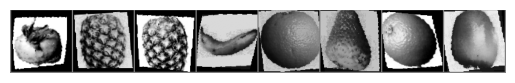

Image 1: Strawberry 1
Image 2: Pineapple 1
Image 3: Pineapple 1
Image 4: Banana 1
Image 5: Orange 1
Image 6: Strawberry 1
Image 7: Orange 1
Image 8: Kaki 1


In [10]:
images, labels = next(iter(train_loader))
show_batch(images, labels, class_names, grayscale=True, n=8)


### 2.5 Summary

This step produces:
- Augmented grayscale training data
- Clean grayscale validation and test data
- Consistent size and normalization across sets

These preprocessing pipelines are now ready to feed into our baseline CNN model (Step 3).

---

####  Note:
Although all data is stored and loaded in float32 by default, the model will be quantized to int8 precision after training (Step 6).